In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import joblib
import pickle

In [2]:
df = pd.read_csv("diamonds.csv")

### Checking the data

In [3]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
df.shape

(53940, 10)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


### Data Preprocessing

In [7]:
# We should delete rows where x, y, z are 0.
df = df.drop(df[df["x"]==0].index)
df = df.drop(df[df["y"]==0].index)
df = df.drop(df[df["y"]==0].index)

In [8]:
df.shape

(53932, 10)

From 53940 to 53932 => 8 faulty rows removed

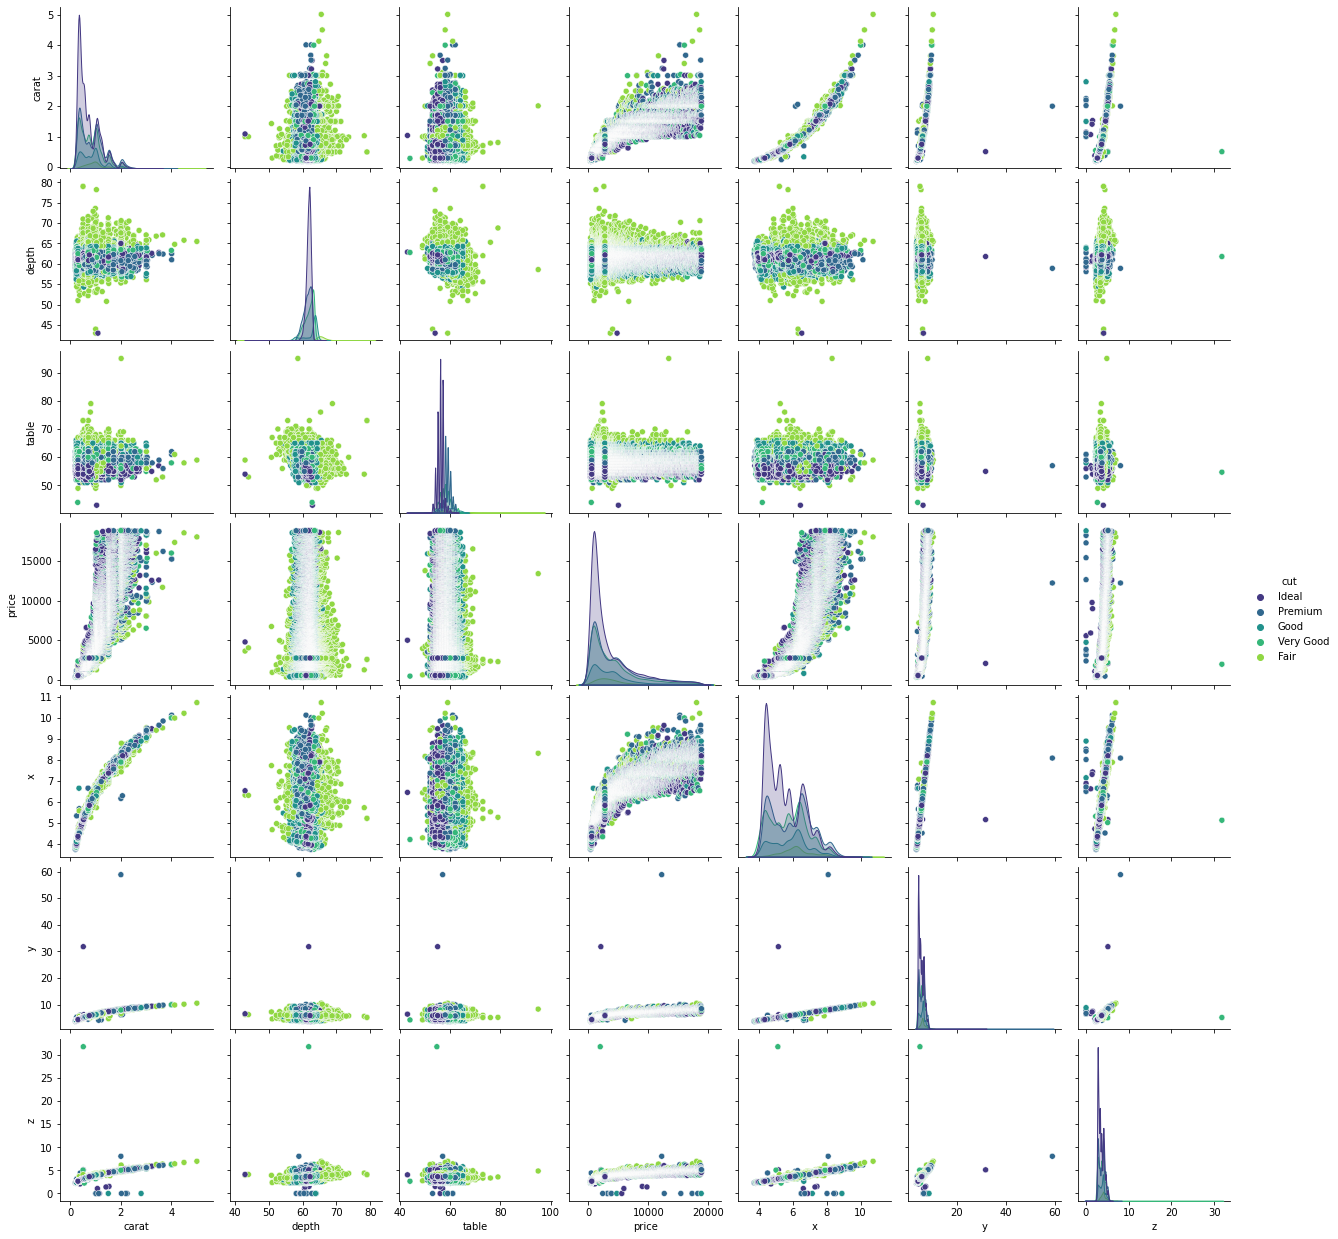

In [9]:
sns.pairplot(data=df, hue="cut", palette="viridis");

There are outliers we need to remove.

In [11]:
df = df.drop(df[(df["carat"]<2) & (df["z"]>20)].index)
df = df.drop(df[(df["carat"]>0) & (df["y"]>20)].index)

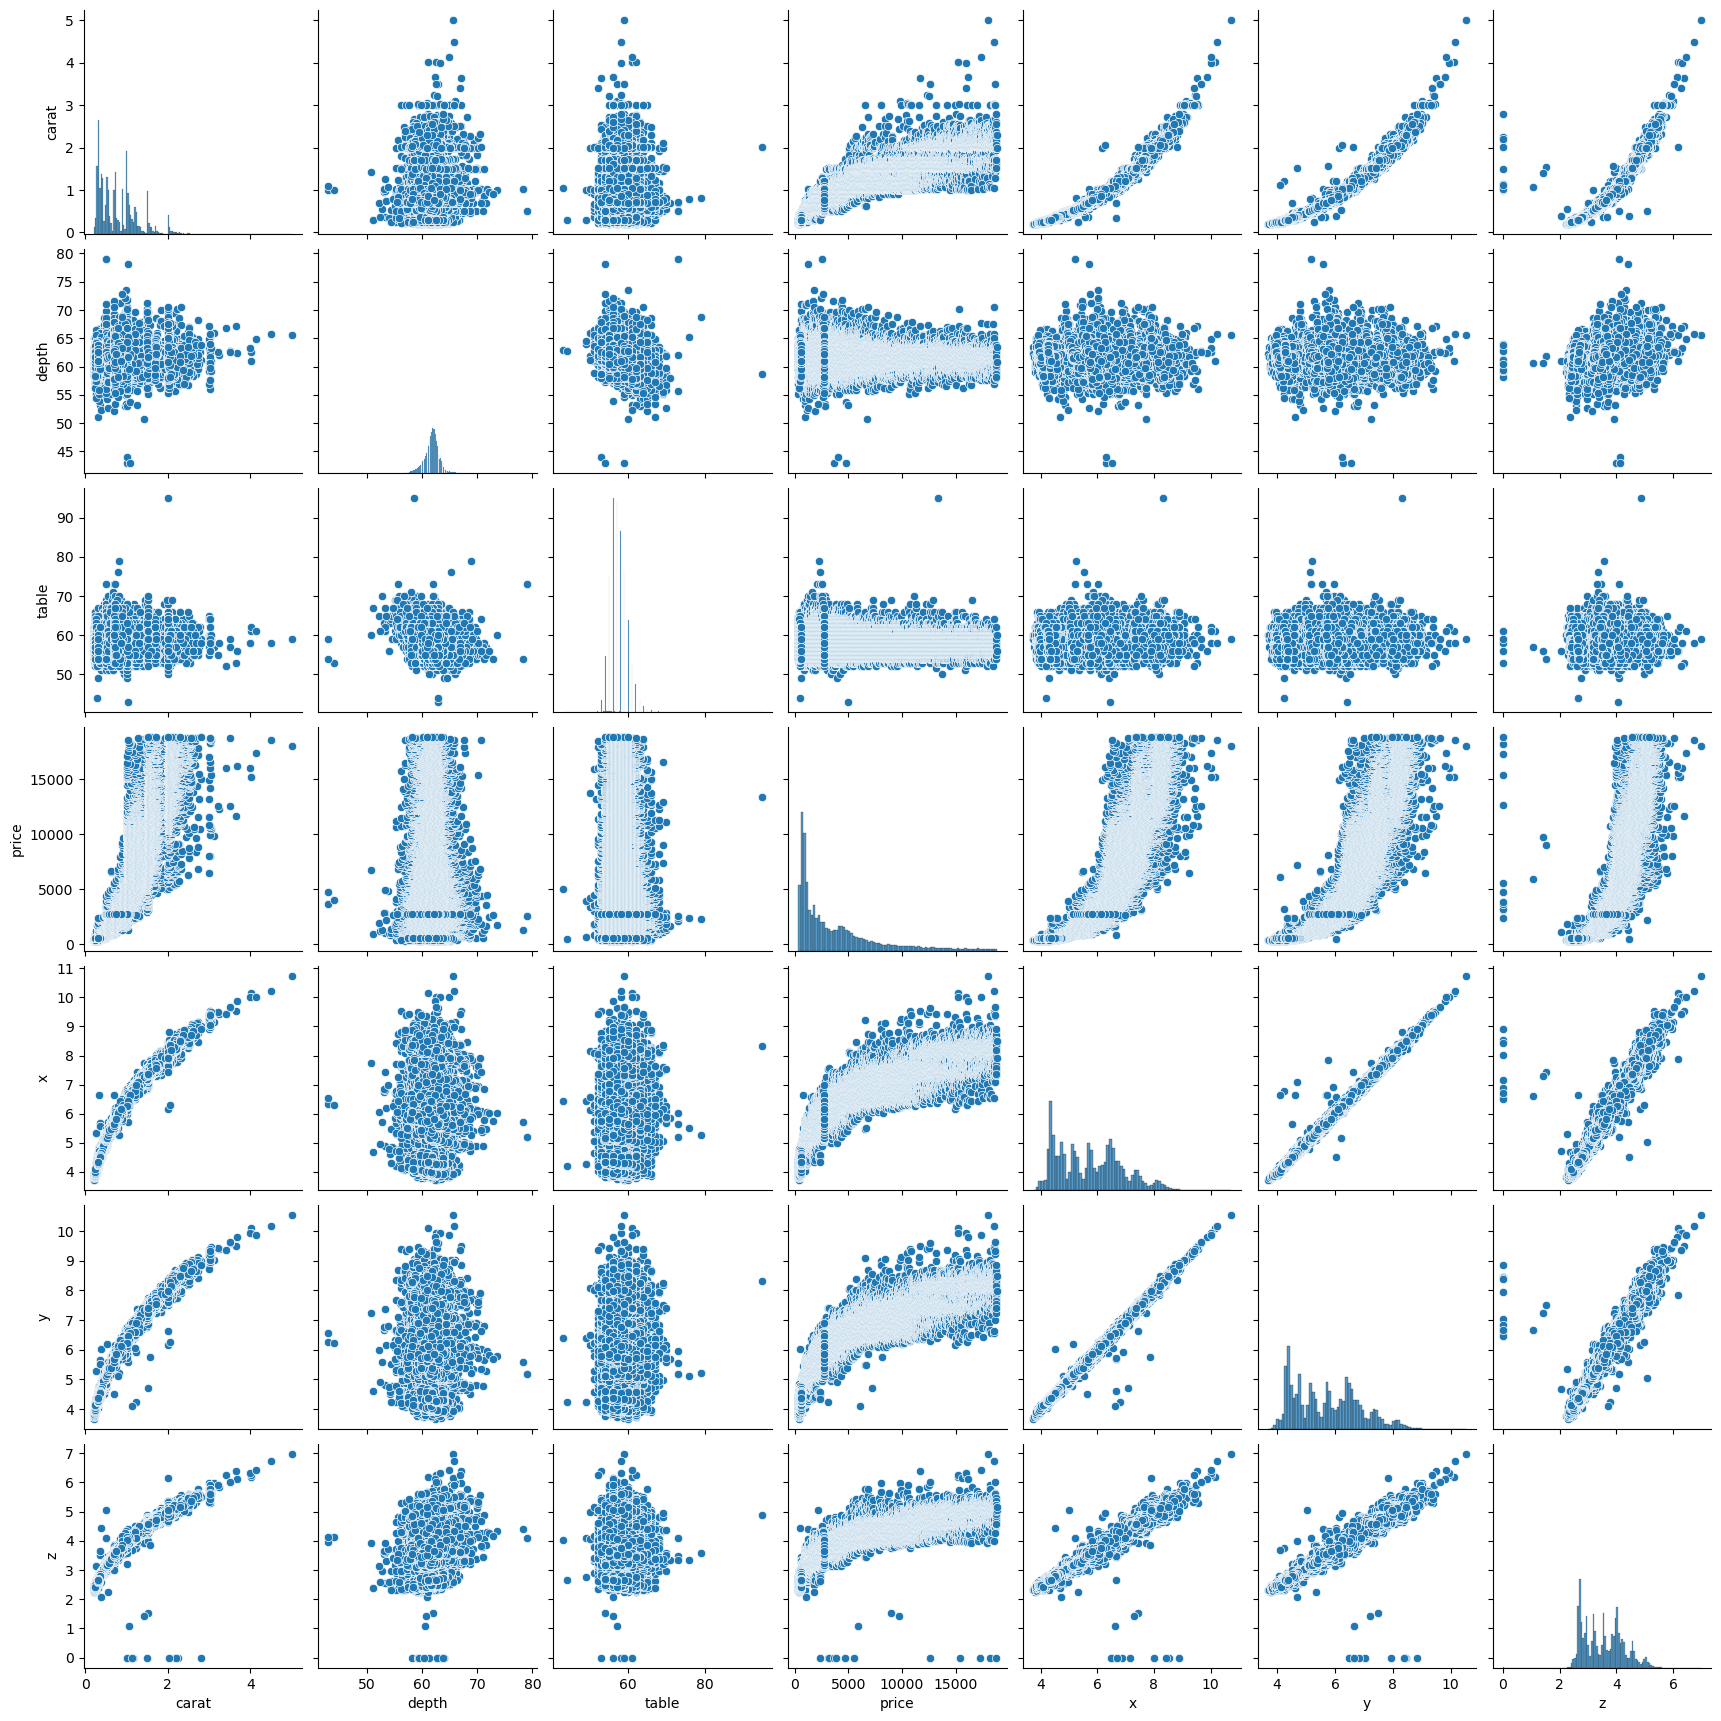

In [12]:
sns.pairplot(df);

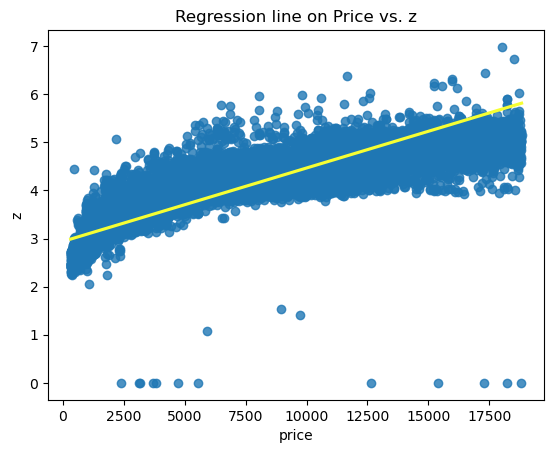

In [13]:
sns.regplot(x="price", y="z", data=df, fit_reg=True, line_kws={"color":"#F6FF33"})
plt.title("Regression line on Price vs. z")
plt.show();

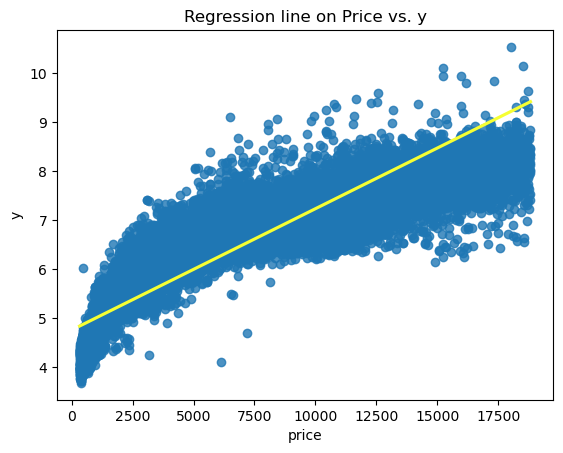

In [14]:
sns.regplot(x="price", y="y", data=df, fit_reg=True, line_kws={"color":"#F6FF33"})
plt.title("Regression line on Price vs. y")
plt.show();

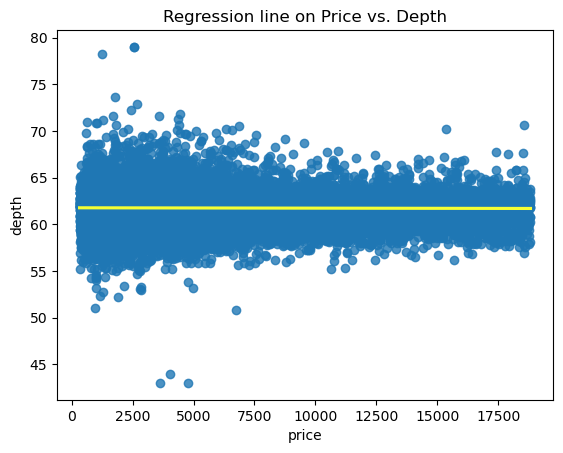

In [15]:
sns.regplot(x="price", y="depth", data=df, fit_reg=True, line_kws={"color":"#F6FF33"})
plt.title("Regression line on Price vs. Depth")
plt.show();

### Dealing with categorical variables

In [16]:
df_objs = (df.dtypes == "object")
object_col = list(df_objs[df_objs].index)
object_col

['cut', 'color', 'clarity']

In [17]:
df[["cut", "color", "clarity"]]

,cut,color,clarity
0,Ideal,E,SI2
1,Premium,E,SI1
2,Good,E,VS1
3,Premium,I,VS2
4,Good,J,SI2
...,...,...,...
53935,Ideal,D,SI1
53936,Good,D,SI1
53937,Very Good,D,SI1
53938,Premium,H,SI2


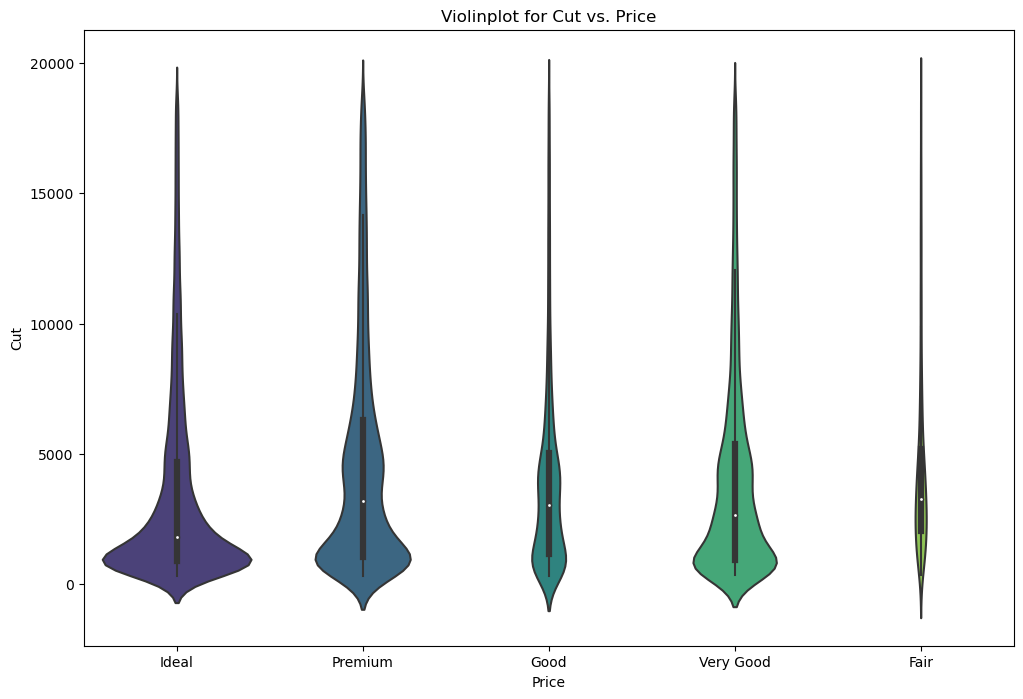

In [18]:
plt.figure(figsize=(12,8), dpi=100)
sns.violinplot(x="cut", y="price", data=df, palette="viridis", scale="count")
plt.title("Violinplot for Cut vs. Price")
plt.xlabel("Price")
plt.ylabel("Cut")
plt.show();

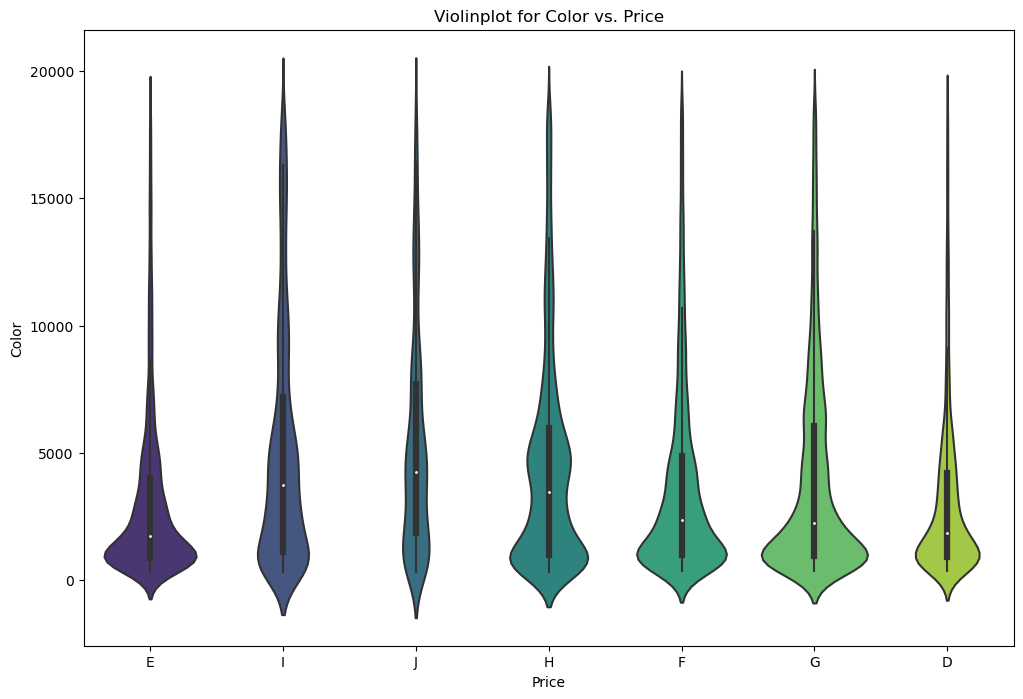

In [19]:
plt.figure(figsize=(12,8), dpi=100)
sns.violinplot(x="color", y="price", data=df, palette="viridis", scale="count")
plt.title("Violinplot for Color vs. Price")
plt.xlabel("Price")
plt.ylabel("Color")
plt.show();

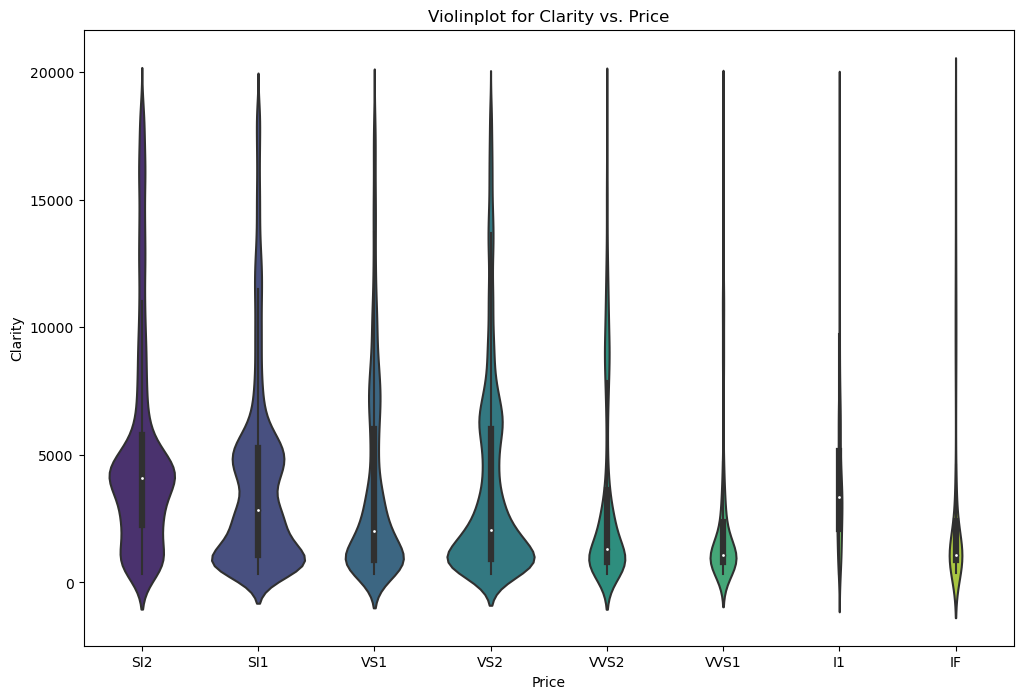

In [20]:
plt.figure(figsize=(12,8), dpi=100)
sns.violinplot(x="clarity", y="price", data=df, palette="viridis", scale="count")
plt.title("Violinplot for Clarity vs. Price")
plt.xlabel("Price")
plt.ylabel("Clarity")
plt.show();

In [21]:
label_data = df.copy()

le = preprocessing.LabelEncoder()

for col in object_col:
    label_data[col] = le.fit_transform(label_data[col])

#export encoder for later use
output = open('model_encoder.pkl', 'wb')
pickle.dump(le, output)
output.close()

In [22]:
label_data[["cut","clarity", "color"]].head(10)

,cut,clarity,color
0,2,3,1
1,3,2,1
2,1,4,1
3,3,5,5
4,1,3,6
5,4,7,6
6,4,6,5
7,4,2,4
8,0,5,1
9,4,4,4


In [23]:
df.describe()

,carat,depth,table,price,x,y,z
count,53929.000000,53929.000000,53929.000000,53929.000000,53929.000000,53929.000000,53929.000000
mean,0.797868,61.749387,57.457134,3932.053404,5.731986,5.733796,3.538622
std,0.473967,1.432502,2.234069,3988.669536,1.119649,1.111501,0.693555
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,0.000000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,10.540000,6.980000


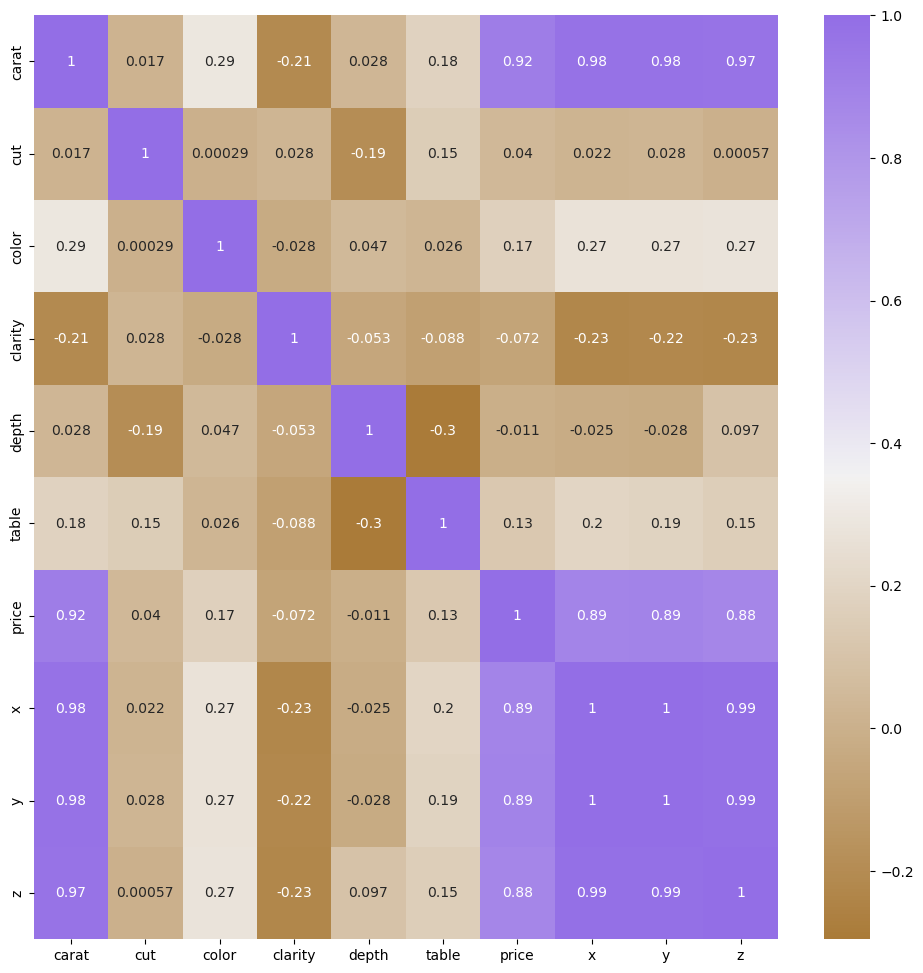

In [25]:
cor_color = sns.diverging_palette(50, 275, s=80, l=55, n=9, as_cmap=True)
corr_data = label_data.corr()

fig, axs = plt.subplots(figsize=(12,12))
sns.heatmap(data=corr_data, cmap=cor_color, annot=True)
plt.show();

x, y, z has high correlation with Price. 

On the other hand depth, cut, table has low correlation. Let's work with 2 versions of data to see how they effect models performance:
* depth, cut, table preserved
* depth, cut, table removed

In [26]:
# 1. depth, cut, table preserved
data_preserved = label_data.copy()
data_preserved.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [27]:
# 2.depth, cut, table removed
data_removed = label_data.drop(label_data[["depth","cut","table"]], axis=1)
data_removed.head()

,carat,color,clarity,price,x,y,z
0,0.23,1,3,326,3.95,3.98,2.43
1,0.21,1,2,326,3.89,3.84,2.31
2,0.23,1,4,327,4.05,4.07,2.31
3,0.29,5,5,334,4.20,4.23,2.63
4,0.31,6,3,335,4.34,4.35,2.75


### Building Models

First model: data_preserved

In [28]:
X = data_preserved.drop(["price"], axis=1)
y = data_preserved["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [29]:
pipeline_linreg = Pipeline([('scaler1', StandardScaler()), ('lr_classifier', LinearRegression())])
pipeline_dtree = Pipeline([('scaler2', StandardScaler()), ('dt_classifier', DecisionTreeRegressor())])
pipeline_ranfor = Pipeline([('scaler3', StandardScaler()), ('rf_classifier', RandomForestRegressor())])
pipeline_knn = Pipeline([('scaler4', StandardScaler()), ('knn_classifier', KNeighborsRegressor())])
pipeline_xgb = Pipeline([('scaler5', StandardScaler()), ('xgb_classifier', XGBRegressor())])
pipelines = [pipeline_linreg, pipeline_dtree, pipeline_ranfor, pipeline_knn, pipeline_xgb]
pipe = {0:"LinearRegression", 1:"DecisionTree", 2:"RandomForest", 3:"KNeighbors", 4:"XGBoost"}

for val in pipelines:
    val.fit(X_train, y_train)

In [30]:
cv_results = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
    cv_results.append(cv_score)
    print(f"{pipe[i]}: {np.abs(cv_score.mean())}")

LinearRegression: 1355.2369734555712
DecisionTree: 764.1644472924708
RandomForest: 559.4482389224892
KNeighbors: 831.855716555933
XGBoost: 557.4701615626025


In [32]:
pred = pipeline_xgb.predict(X_test)
print("R^2: ", metrics.r2_score(y_test, pred))
print("MAE: ", metrics.mean_absolute_error(y_test, pred))
print("MSE: ", metrics.mean_squared_error(y_test, pred))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2:  0.9812531798916697
MAE:  281.8393320267763
MSE:  298305.4396831623
RMSE:  546.1734520124191


In [33]:
joblib.dump(pipeline_xgb, "data_preserved_model.pkl", compress=3)

['data_preserved_model.pkl']

Second model: data_removed

In [34]:
X = data_removed.drop(["price"], axis=1)
y = data_removed["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [35]:
pipeline_linreg2 = Pipeline([('scaler1', StandardScaler()), ('lr_classifier', LinearRegression())])
pipeline_dtree2 = Pipeline([('scaler2', StandardScaler()), ('dt_classifier', DecisionTreeRegressor())])
pipeline_ranfor2 = Pipeline([('scaler3', StandardScaler()), ('rf_classifier', RandomForestRegressor())])
pipeline_knn2 = Pipeline([('scaler4', StandardScaler()), ('knn_classifier', KNeighborsRegressor())])
pipeline_xgb2 = Pipeline([('scaler5', StandardScaler()), ('xgb_classifier', XGBRegressor())])
pipelines2 = [pipeline_linreg2, pipeline_dtree2, pipeline_ranfor2, pipeline_knn2, pipeline_xgb2]
pipe2 = {0:"LinearRegression", 1:"DecisionTree", 2:"RandomForest", 3:"KNeighbors", 4:"XGBoost"}

for val in pipelines2:
    val.fit(X_train, y_train)

In [36]:
cv_results2 = []
for i, model in enumerate(pipelines2):
    cv_score = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
    cv_results.append(cv_score)
    print(f"{pipe2[i]}: {np.abs(cv_score.mean())}")

LinearRegression: 1370.5845525874192
DecisionTree: 768.8612798369358
RandomForest: 576.8600667239448
KNeighbors: 591.1214362544921
XGBoost: 573.0726069657351


In [37]:
pred2 = pipeline_xgb2.predict(X_test)
print("R^2: ", metrics.r2_score(y_test, pred2))
print("MAE: ", metrics.mean_absolute_error(y_test, pred2))
print("MSE: ", metrics.mean_squared_error(y_test, pred2))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, pred2)))

R^2:  0.9806799783993545
MAE:  291.14272331691905
MSE:  307426.40645001014
RMSE:  554.4604642803761


In [38]:
joblib.dump(pipeline_xgb2, "data_removed_model.pkl", compress=3)

['data_removed_model.pkl']